In [13]:
#Importing libraries
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import os
from torchvision.datasets import ImageFolder
from torch.utils.data import random_split
import torch.nn as nn
import torch.nn.functional as F

In [14]:
#Images files folder
path = r'D:\VinUni materials\Third Year\Fall Semester 2022\COMP3020 - Machine Learning\Project\GUI application\Official_Data'
data_dir = r'D:\VinUni materials\Third Year\Fall Semester 2022\COMP3020 - Machine Learning\Project\GUI application\Official_Data\train'

In [15]:
#Normalizing, rotating and flipping the images by transforming using pytorch methods.
transformer = torchvision.transforms.Compose(
    [ # Applying Augmentation
        torchvision.transforms.Resize((144,144 )),
        torchvision.transforms.RandomHorizontalFlip(p=0.5),
        torchvision.transforms.RandomVerticalFlip(p=0.5),
        torchvision.transforms.RandomRotation(10),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(
            mean=[0.5, 0.5, 0.5], std=[0.2, 0.2, 0.2]
        ),
    ]
)
database = ImageFolder(data_dir, transform=transformer)

In [16]:
#Setting the validation size
validation_size = 274
training_size = len(database) - validation_size
print(len(database))

2738


In [17]:
#Splitting data in test and train dataset
trainset, testset = random_split(database, [training_size, validation_size])

In [18]:
#Initializing batch size and creating list of batches in train and test datasets
batch_size = 16
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

In [19]:
#Total classes or types of flowers
database.classes

['autistic', 'non_autistic']

In [20]:
classes = ('autistic', 'non_autistic')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


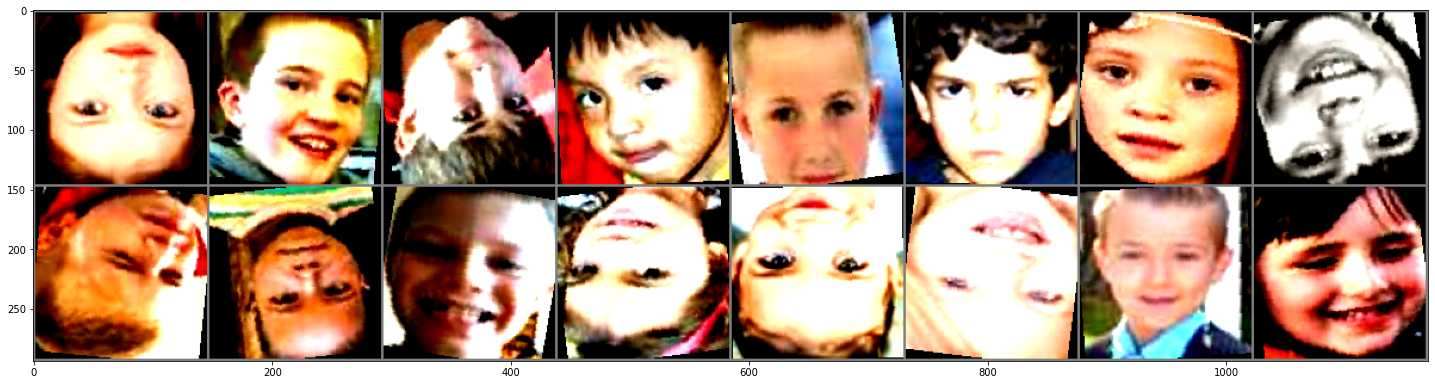

non_autistic autistic autistic autistic non_autistic autistic non_autistic autistic autistic non_autistic autistic autistic non_autistic non_autistic non_autistic non_autistic


In [21]:
#Showing {batch_size} random images from a single random batch in a grid format
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    fig, ax = plt.subplots(figsize=(25, 25))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [22]:
# Creating a custom CNN model with 3 convolutional layers and 3 pooling layers, 1 fully connected layers.
''' in_channels: It is the number of channels in the input image, 
which is 3 in this case (representing RGB channels). '''

''' out_channels: It is the number of filters used in the convolution operation. 
A higher number of filters increases the capacity of the model to learn more complex features. 
However, too many filters can lead to overfitting. A common rule of thumb is to start with a 
small number (e.g. 32 or 64) and gradually increase it until see improvement. '''

'''kernel_size: It is the size of the filters used in the convolution operation. 
    Larger filters can capture more complex features, but also increase the number of parameters in 
    the model and the computational cost. A common choice is 3x3 or 5x5. '''

''' stride: It is the step size that the filter takes when sliding over the input image. 
    Larger strides reduce the spatial dimensions of the output, but also reduce the ability 
    of the model to capture fine-grained details. A common choice is 1 or 2. '''

'''padding: It is the number of pixels added to the input image along the border to preserve the 
    spatial dimensions of the output. Padding with 0s can help the model capture features 
    at the edges of the image. A common choice is to use padding so that the spatial dimensions 
    of the output are the same as the input. '''

class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=58, kernel_size=3, stride=2, padding=3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(58, 116, kernel_size=3, stride=2, padding=3)
        self.conv3 = nn.Conv2d(116, 232, kernel_size=3, stride=2, padding=3)
        self.fc1 = nn.Linear(232*3*3, 2088)
        self.fc2 = nn.Linear(2088, 2)   # binary classification

    def forward(self, x):

        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = torch.flatten(x, 1) 
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

    
cnn = CNN()

In [23]:
import torch.optim as optim
#Initializing learning rate and beta value ; creating optimizer
criterion = nn.CrossEntropyLoss()
lr_dynamic = 0.01
momentum_dynamic = 0.9
optimizer = optim.SGD(cnn.parameters(), lr=lr_dynamic, momentum=momentum_dynamic)

In [12]:
#Initializing lists for plotting the graphs of epoch vs loss
Epoch_list =[]
Loss_list =[]

print("Started training!")
for epoch in range(50):  # loop over the dataset multiple times
    if epoch >= 10:
      if sum(Loss_list[-5:]) > sum(Loss_list[-10:-5]):
        break
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = cnn(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 100 == 99:    
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 100:.3f}')
            if i==99:
              Epoch_list.append((epoch) + 0.25)
              Loss_list.append(running_loss)
            if i==199:
              Epoch_list.append((epoch) + 0.5)
              Loss_list.append(running_loss)
            if i==299:
              Epoch_list.append((epoch) + 0.75)
              Loss_list.append(running_loss)
            if i==399:
              Epoch_list.append((epoch) + 1)
              Loss_list.append(running_loss)

            running_loss = 0.0
            #Adjusting the learning rate for every approx half epoch with decay rate of 0.96
            lr_dynamic = 0.96*lr_dynamic
            optimizer = optim.SGD(cnn.parameters(), lr=lr_dynamic, momentum=momentum_dynamic) 

print('Finished Training!')

Started training!
[1,   100] loss: 0.688
[2,   100] loss: 0.662
[3,   100] loss: 0.624
[4,   100] loss: 0.634
[5,   100] loss: 0.573
[6,   100] loss: 0.583
[7,   100] loss: 0.559
[8,   100] loss: 0.567
[9,   100] loss: 0.547
[10,   100] loss: 0.519
[11,   100] loss: 0.516
[12,   100] loss: 0.510
[13,   100] loss: 0.481
[14,   100] loss: 0.472
[15,   100] loss: 0.480
[16,   100] loss: 0.476
[17,   100] loss: 0.444
[18,   100] loss: 0.435
[19,   100] loss: 0.434
[20,   100] loss: 0.425
[21,   100] loss: 0.400
[22,   100] loss: 0.422
[23,   100] loss: 0.386
[24,   100] loss: 0.401
[25,   100] loss: 0.367
[26,   100] loss: 0.377
[27,   100] loss: 0.357
[28,   100] loss: 0.357
[29,   100] loss: 0.382
[30,   100] loss: 0.351
[31,   100] loss: 0.318
[32,   100] loss: 0.326
[33,   100] loss: 0.318
[34,   100] loss: 0.316
[35,   100] loss: 0.296
[36,   100] loss: 0.269
[37,   100] loss: 0.270
[38,   100] loss: 0.284
[39,   100] loss: 0.275
[40,   100] loss: 0.262
[41,   100] loss: 0.248
[42,   

<AxesSubplot:xlabel='Batch-Epoch'>

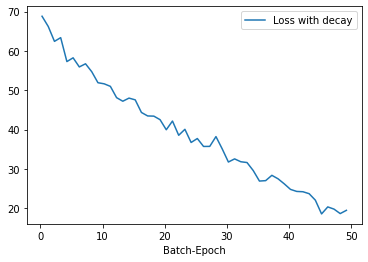

In [13]:
#Plotting the graphs epoch vs loss
loss_df = pd.DataFrame(data={'Batch-Epoch': Epoch_list, 
                        'Loss with decay': Loss_list})
fig, ax = plt.subplots() # Create the figure and axes object

loss_df.plot(x = 'Batch-Epoch', y = 'Loss with decay', ax = ax) 

In [14]:
#Saving the model
path_cnn = path + r'\CNN_model.pth'
torch.save(cnn.state_dict(), path_cnn)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


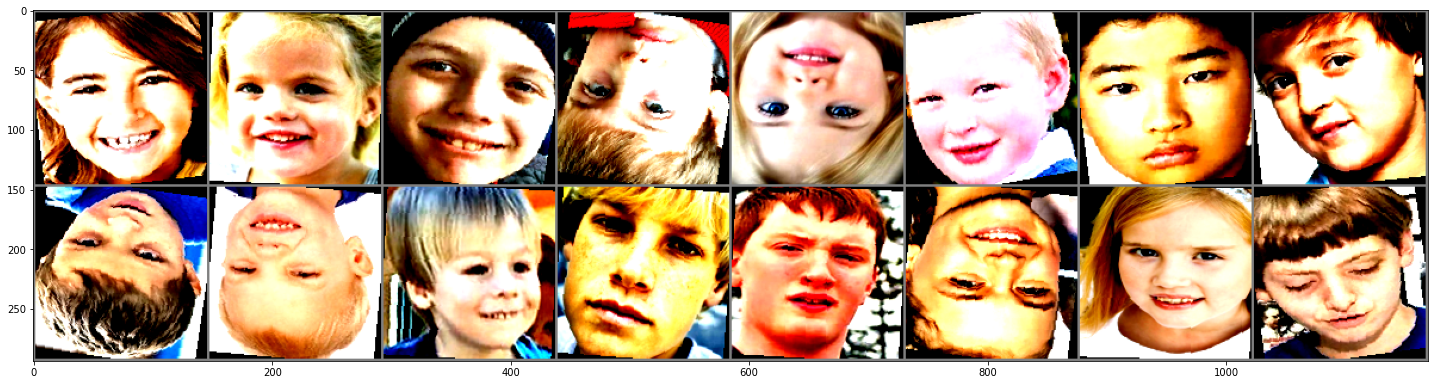

GroundTruth:  non_autistic non_autistic autistic autistic non_autistic autistic non_autistic non_autistic autistic autistic autistic autistic autistic non_autistic non_autistic autistic
Predicted:  non_autistic non_autistic autistic autistic non_autistic non_autistic non_autistic autistic autistic non_autistic autistic autistic autistic autistic non_autistic autistic


In [15]:
#Showing {batch_size} sample images of test dataset
dataiter = iter(testloader)
images, labels = next(dataiter)

#Sample testing on model
cnn = CNN()
cnn.load_state_dict(torch.load(path_cnn))
outputs = cnn(images)

#Sample predictions
_, predicted = torch.max(outputs, 1)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))
print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(batch_size)))

In [18]:
#Series and dataframes to store actual and predicted values.
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in trainloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = cnn(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the train images: {100 * correct // total} %')

Accuracy of the network on the train images: 93 %


In [27]:
#Series and dataframes to store actual and predicted values.
test_results = pd.DataFrame(columns = ['Actual_Image','Predicted_Image'])
Actual_Image= pd.Series(name='Actual_Image',dtype = str)
Predicted_Image= pd.Series(name='Predicted_Image',dtype = str)
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = cnn(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        Actual_Image = pd.concat([Actual_Image, pd.Series(labels.tolist(), name='Actual_Image')], ignore_index=True)
        Predicted_Image = pd.concat([Predicted_Image, pd.Series(predicted.tolist(), name='Predicted_Image')], ignore_index=True)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Total images: {total}')
print(f'Incorrect prediction: {total - correct}')
print(f'Accuracy of the network on the {validation_size} validation images: {100 * correct // total} %')


Total images: 274
Incorrect prediction: 68
Accuracy of the network on the 220 validation images: 75.18248175182482 %


In [21]:
#Creating the test results dataframe
test_results = pd.concat([Actual_Image,Predicted_Image], axis = 1)

test_results['Actual_Image']    = test_results['Actual_Image'].map({0:'autistic',1: 'non_autistic'})
test_results['Predicted_Image'] = test_results['Predicted_Image'].map({0:'autistic',1: 'non_autistic'})
display(test_results)

,Actual_Image,Predicted_Image
0,non_autistic,non_autistic
1,non_autistic,non_autistic
2,autistic,autistic
3,autistic,autistic
4,non_autistic,non_autistic
...,...,...
215,autistic,autistic
216,autistic,non_autistic
217,autistic,autistic
218,autistic,non_autistic


In [22]:
#Printing the metrics like confution matrix of final model prediction and also classification report.
print("Confusion matrix with true and predicted counts of each class with ID:")
display(pd.crosstab(test_results['Actual_Image'].squeeze(), test_results['Predicted_Image'].squeeze(), rownames=['True'], colnames=['Predicted'], margins=True))

Confusion matrix with true and predicted counts of each class with ID:


Predicted,autistic,non_autistic,All
True,,,
autistic,93,28,121
non_autistic,27,72,99
All,120,100,220


In [19]:
# Calculate accuracy on real test dataset

predict_dir = r'D:\VinUni materials\Third Year\Fall Semester 2022\COMP3020 - Machine Learning\Project\GUI application\Official_Data\test'
predict_set = ImageFolder(predict_dir, transform=transformer)
predict_loader = torch.utils.data.DataLoader(predict_set, batch_size=batch_size,
                                         shuffle=False, num_workers=2)
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in predict_loader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = cnn(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Total images: {total}')
print(f'Incorrect prediction: {total - correct}')
print(f'Accuracy of the network on the {total} test images: {100 * correct // total} %')


Total images: 202
Incorrect prediction: 15
Accuracy of the network on the 202 test images: 92.57425742574257 %


### GUI app for demo

C:\Users\lamvo\AppData\Local\Temp\ipykernel_18624\1992285866.py:24: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  bg = bg.resize((win.winfo_screenwidth(), win.winfo_screenheight()), Image.ANTIALIAS)


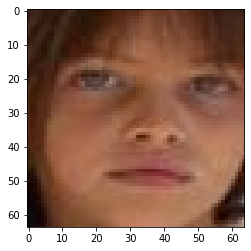

C:\Users\lamvo\AppData\Local\Temp\ipykernel_18624\1992285866.py:84: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probabilities = sm(outputs)


[[ 7.1646996 92.835304 ]]
autistic        :    7.1647 %
non_autistic    :    92.8353 %


 Final Predicted image :  NON_AUTISTIC


In [24]:
import tkinter as tk
from tkinter import filedialog
from tkinter.filedialog import askopenfile
from PIL import Image, ImageTk
from tkinter import *
from PIL import Image
from torch.autograd import Variable
import matplotlib.image as mpimg
import cv2

img_path = r'D:\VinUni materials\Third Year\Fall Semester 2022\COMP3020 - Machine Learning\Project\GUI application\images'

win = tk.Tk()
win.geometry("1200x800")
win.title('Autism Detection')

icon = PhotoImage(file = img_path + r'\icon.png')
  
# Setting icon of master window
win.iconphoto(False, icon)

# Set background image
bg = Image.open(img_path + r'\bg1.png')
bg = bg.resize((win.winfo_screenwidth(), win.winfo_screenheight()), Image.ANTIALIAS)
bg = ImageTk.PhotoImage(bg)
my_label = Label(win, image= bg)
my_label.pack(fill='both', expand='yes')

# Title
font = ('georgia', 30, 'bold')
title = Label(win, text='Autism Image Detector                                                                                                               ')
title.config(bg='#2F221B', fg='dark goldenrod')
title.config(font=font)
title.config(height=2, width=110)
title.place(x=0, y=0)

font1 = ('georgia', 16, 'bold')
prob_result = Text(win, height=10, width=50, bd = 3, relief = "solid")

myscrollbar=Scrollbar(prob_result)
prob_result.configure(yscrollcommand=myscrollbar.set)
prob_result.place(x=900, y=220)  # 50
prob_result.config(font=font1)

font = ('georgia', 16, 'bold')
pred_label = Label(win, text='---- PREDICTION ----', bd = 4, relief = "solid")
pred_label.config(bg='white', fg='dark goldenrod')
pred_label.config(font=font)
pred_label.config(height=3, width=20)
pred_label.place(x=900, y=550)

font1 = ('georgia', 18, 'bold')
predict = Text(win, height=3, width=25, bd = 3, relief = "solid", wrap = 'word')
predict.place(x=900, y=650)
predict.config(font=font1)

# Frame for displaying image
pic_frame = PhotoImage(file = img_path + r'\pic_frame.png')
frame = Frame(win)

# Create a Label widget to display the image
background_label = tk.Label(frame, image=pic_frame, width=700, height=600, bd = 5, relief = 'solid')
background_label.pack(fill="both", expand=True)

frame.pack()
frame.place(x=100, y=120)

img_to_process = None

def get_probabilities(image):
  imgplot = plt.imshow(image)
  plt.show()
  image = transformer(image)
  image = image.float()
  image = Variable(image, requires_grad=True)
  image = image.unsqueeze(0)  
  cnn = CNN()
  path_cnn = path + r'\CNN_model.pth'
  cnn.load_state_dict(torch.load(path_cnn))
    
  outputs = cnn(image)
  _, predicted = torch.max(outputs.data, 1)
  sm = torch.nn.Softmax()
  probabilities = sm(outputs) 
  probabilities = probabilities.detach().numpy()
  print(probabilities*100) #Converted to probabilities
  prob_result.delete('1.0', END)
  predict.delete('1.0',END)
  predict.insert(END, (classes[predicted.tolist()[0]]).upper())
  for i,j in enumerate(probabilities[0]):
    str_display = classes[i].ljust(15, ' ')  + ':   ' +  str(round(j*100,4)) + '%\n'
    prob_result.insert(END, str_display)
    print(classes[i].ljust(15, ' ') ,':   ', round(j*100,4),'%')
  print('\n\n Final Predicted image : ', classes[predicted.tolist()[0]].upper())

def upload_file():
    global img, img_to_process
    for widget in frame.winfo_children():
        widget.destroy()
    f_types = [('Jpg Files', '*.jpg')]
    filename = filedialog.askopenfilename(filetypes=f_types)
    img=Image.open(filename)
    img_to_process = img
#     get_probabilities(img)
    image2= img
       
    img_resized=img.resize((700,600)) # new width & height
    img=ImageTk.PhotoImage(img_resized)

    label = Label(frame, image = img)
    label.pack()
    
def take_picture():
    global img_to_process

    cap = cv2.VideoCapture(0)
    ret, frame1 = cap.read()
    cap.release()
    frame1 = cv2.cvtColor(frame1, cv2.COLOR_BGR2RGB)
    image = Image.fromarray(frame1)
    image.save("D:\VinUni materials\Third Year\Fall Semester 2022\COMP3020 - Machine Learning\Project\GUI application\Official_Data\captured_images\captured_image.jpg")
    image = Image.open("D:\VinUni materials\Third Year\Fall Semester 2022\COMP3020 - Machine Learning\Project\GUI application\Official_Data\captured_images\captured_image.jpg")
    img_to_process = image
    
    photo = ImageTk.PhotoImage(image)

    background_label.config(image=photo)
    background_label.image = photo
#     get_probabilities(image)


def close():
   win.destroy()

upload_button = Button(win,text='Upload \nImage', width=20, relief="solid", command = lambda:upload_file())
upload_button.config(font=('georgia', 14, 'bold'))
upload_button.place(x=150, y=750)

predict_button = Button(win,text='Start \nPrediction', width=20, relief="solid", command = lambda:get_probabilities(img_to_process))
predict_button.config(font=('georgia', 14, 'bold'))
predict_button.place(x=300, y=850)

font = ('black', 10, 'bold')
probabilities_label = Label(win, text=' ---- PROBABILITIES OF AUTISM ----', bd = 4, relief = 'solid')
probabilities_label.config(bg='white', fg='dark goldenrod')
probabilities_label.config(font=('georgia', 16, 'bold'))
probabilities_label.config(height=3, width=34)
probabilities_label.place(x=900, y=120)

take_img_button = Button(win, text="Take \nImage", width = 20, relief="solid", command=lambda:take_picture())
take_img_button.place(x=460, y=750)
take_img_button.config(font=('georgia', 14, 'bold'))

win.mainloop()  # Keep the window open

In [1]:
# rename files
import os
path = 'D:/VinUni materials/Third Year/Fall Semester 2022/COMP3020 - Machine Learning/Project/GUI application/Official_Data/train'
files = os.listdir(path)

count = 1
for index, file in enumerate(files):
    os.rename(os.path.join(path, file), os.path.join(path, ''.join([str(count), '.jpg'])))
    count += 1


In [2]:
# Find duplicate images
from PIL import Image
import imagehash
import os
import numpy as np

class DuplicateRemover:
    def __init__(self,dirname,hash_size = 8):
        self.dirname = dirname
        self.hash_size = hash_size
        
    def find_duplicates(self):
        """
        Find and Delete Duplicates
        """
        
        fnames = os.listdir(self.dirname)
        hashes = {}
        duplicates = []
        print("Finding Duplicates Now!\n")
        for image in fnames:
            with Image.open(os.path.join(self.dirname,image)) as img:
                temp_hash = imagehash.average_hash(img, self.hash_size)
                if temp_hash in hashes:
                    print("Duplicate {} \nfound for Image {}!\n".format(image,hashes[temp_hash]))
                    duplicates.append(image)
                else:
                    hashes[temp_hash] = image
                   
        if len(duplicates) != 0:
            a = input("Do you want to delete these {} Images? Press Y or N:  ".format(len(duplicates)))
            space_saved = 0
            if(a.strip().lower() == "y"):
                for duplicate in duplicates:
                    space_saved += os.path.getsize(os.path.join(self.dirname,duplicate))
                    
                    os.remove(os.path.join(self.dirname,duplicate))
                    print("{} Deleted Succesfully!".format(duplicate))
    
                print("\n\nYou saved {} mb of Space!".format(round(space_saved/1000000),2))
            else:
                print("Thank you for Using Duplicate Remover")
        else:
            print("No Duplicates Found :(")
            
        
            
            
    def find_similar(self,location,similarity=80):
        fnames = os.listdir(self.dirname)
        threshold = 1 - similarity/100
        diff_limit = int(threshold*(self.hash_size**2))
        
        with Image.open(location) as img:
            hash1 = imagehash.average_hash(img, self.hash_size).hash
        
        print("Finding Similar Images to {} Now!\n".format(location))
        for image in fnames:
            with Image.open(os.path.join(self.dirname,image)) as img:
                hash2 = imagehash.average_hash(img, self.hash_size).hash
                
                if np.count_nonzero(hash1 != hash2) <= diff_limit:
                    print("{} image found {}% similar to {}".format(image,similarity,location))
                    
                    
                            
dirname = "D:/VinUni materials/Third Year/Fall Semester 2022/COMP3020 - Machine Learning/Project/Official_Data/train/autistic"

# Remove Duplicates
dr = DuplicateRemover(dirname)
dr.find_duplicates()

# # Find Similar Images
# dr.find_similar("IMG-20110704-00007.jpg",70)
            